# Abstract

Check whether LO really helps.

Select a few pairs, manually annotate and measure eucledian distance.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

---

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

---

In [3]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


---

In [4]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [5]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

6.571540417004144

---

In [6]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

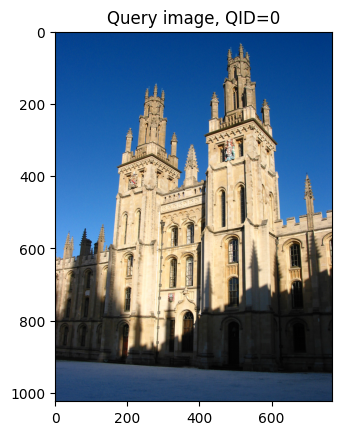

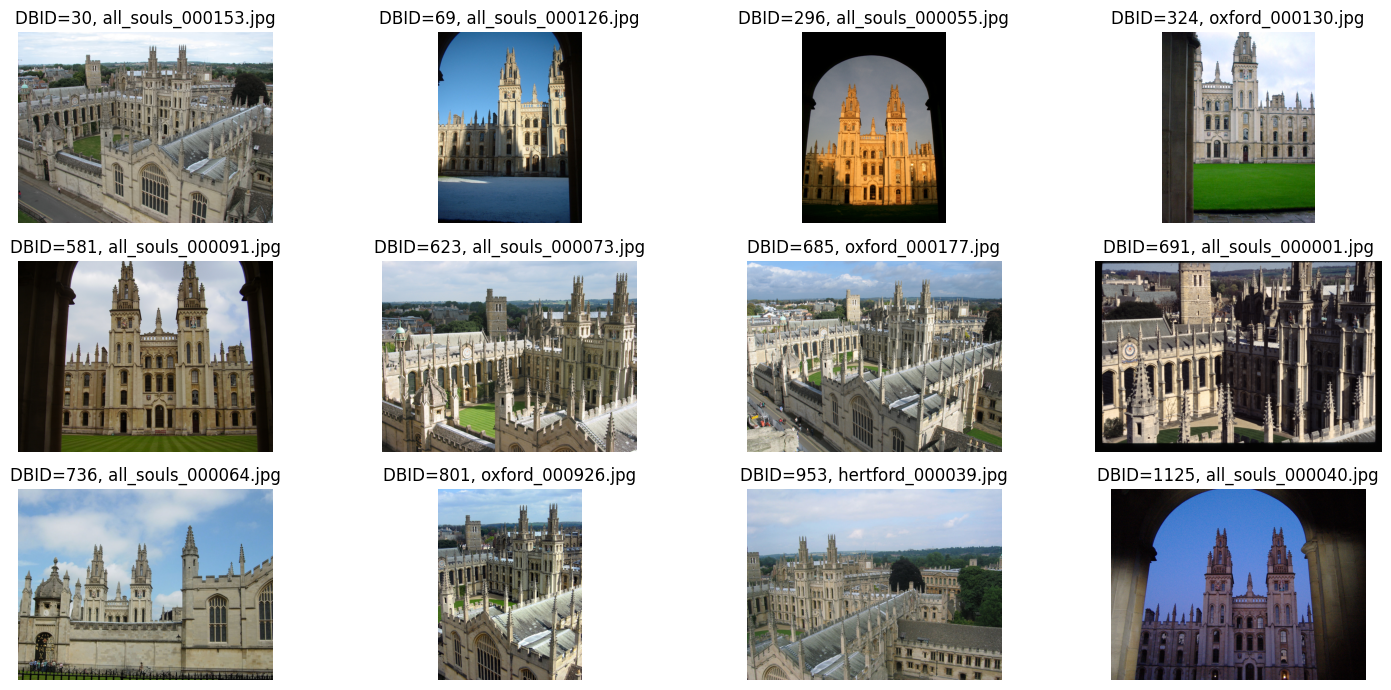

In [105]:
qi = 0

query_img = plt.imread(IMAGES_ROOT / f'{gnd["qimlist"][qi]}.jpg')

plt.title(f'Query image, QID={qi}')
plt.imshow(query_img)
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(15, 7))
for i in range(12):
    dbi = gnd['gnd'][qi]['easy'][i]
    result_img = plt.imread(IMAGES_ROOT / f'{gnd["imlist"][dbi]}.jpg')
    
    ax[i // 4, i % 4].imshow(result_img)
    ax[i // 4, i % 4].set_title(f'DBID={dbi}, {gnd["imlist"][dbi]}.jpg')
    ax[i // 4, i % 4].axis('off')
fig.tight_layout()
plt.show()

In [119]:
pairs = [
    (0, 296),
    (2, 581),
    (5, 2200),
    (10, 933),
    (15, 314),
    (16, 233),
    (19, 1184),
    (25, 2468),
    (30, 88),
    (32, 1375),
    (35, 3951),
    (45, 3723),
    (53, 29),
]

In [120]:
for qi, dbi in pairs:
    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]
    
    ########################
    # SPATIAL VERIFICATION #
    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    assert similarities.size
    _similarities = similarities * (similarities > 0)
    
    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    
    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )
        
    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)
    
    # Compute scores
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_hypothesis_index = scores.argmax()
    
    # Local optimization
    A = hypotheses[best_hypothesis_index]
    mask = verifications[best_hypothesis_index]
        
    support = mask.sum()
    
    print('START:', support, 'LO:', end='')
        
    while True:
        new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
        errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
        mask = verify_models(errors, corrs)[0]
        new_support = mask.sum()
        
        print(new_support, end=' ')

        if new_support > support:
            support = new_support
            A = new_A
        else:
            break
    print()

START: 71 LO:87 95 99 101 103 107 108 108 
START: 299 LO:298 
START: 160 LO:172 170 
START: 18 LO:18 
START: 43 LO:52 55 56 56 
START: 16 LO:15 
START: 47 LO:57 59 57 
START: 33 LO:45 49 48 
START: 94 LO:99 99 
START: 125 LO:123 
START: 80 LO:87 87 
START: 154 LO:182 186 188 187 
START: 70 LO:74 78 78 


In [121]:
pairs = [
    (0, 296),
    # (2, 581),
    (5, 2200),
    # (10, 933),
    (15, 314),
    # (16, 233),
    (19, 1184),
    (25, 2468),
    (30, 88),
    # (32, 1375),
    (35, 3951),
    (45, 3723),
    (53, 29),
]

In [122]:
transformations = []

for qi, dbi in pairs:
    # Query data
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]
    
    # Database data
    dbl = np.searchsorted(desc['imids'], dbi, 'left')
    dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
    db_vecs = desc['vecs'][dbl:dbr]
    db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
    db_coordx = desc['coordx'][dbl:dbr]
    db_coordy = desc['coordy'][dbl:dbr]
    db_scales = desc['scales'][dbl:dbr]
    db_residuals = db_residual_packs[dbl:dbr]
    
    ########################
    # SPATIAL VERIFICATION #
    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    assert similarities.size
    _similarities = similarities * (similarities > 0)
    
    # Pick corresponding data
    scales1 = scales[q_scales[corrs[:, 0]]]
    coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
    coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

    scales2 = scales[db_scales[corrs[:, 1]]]
    coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
    coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
    
    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )
        
    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)
    
    # Compute scores
    scores = (verifications * _similarities[np.newaxis]).sum(axis=1)
    best_hypothesis_index = scores.argmax()
    
    # Local optimization
    A = hypotheses[best_hypothesis_index]
    mask = verifications[best_hypothesis_index]
        
    support = mask.sum()
    
    print('START:', support, 'LO:', end='')
        
    while True:
        new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
        errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
        mask = verify_models(errors, corrs)[0]
        new_support = mask.sum()
        
        print(new_support, end=' ')

        if new_support > support:
            support = new_support
            A = new_A
        else:
            break
            
    transformations.append((hypotheses[best_hypothesis_index], A))
    print()

transformations = np.asarray(transformations)
transformations.shape

START: 71 LO:87 95 99 101 103 107 108 108 
START: 160 LO:172 170 
START: 43 LO:52 55 56 56 
START: 47 LO:57 59 57 
START: 33 LO:45 49 48 
START: 94 LO:99 99 
START: 80 LO:87 87 
START: 154 LO:182 186 188 187 
START: 70 LO:74 78 78 


(9, 2, 3, 3)

In [123]:
for qi, dbi in pairs:
    print(f'{gnd["qimlist"][qi]}.jpg \t {gnd["imlist"][dbi]}')

all_souls_000013.jpg 	 all_souls_000055
ashmolean_000058.jpg 	 oxford_001964
bodleian_000107.jpg 	 bodleian_000085
bodleian_000163.jpg 	 bodleian_000208
cornmarket_000047.jpg 	 oxford_000601
hertford_000015.jpg 	 hertford_000070
keble_000245.jpg 	 oxford_002501
pitt_rivers_000033.jpg 	 pitt_rivers_000115
radcliffe_camera_000095.jpg 	 radcliffe_camera_000139


In [126]:
ground_truth_correspondences = np.array([
    [
        [
            [169, 268, 213, 410, 550, 480, 313, 384, 370, 206, 513],
            [376, 343, 440, 289, 242, 360, 725, 637, 790, 789, 824],
        ],
        [
            [196, 310, 310, 449, 561, 507, 329, 396, 377, 276, 533],
            [462, 464, 465, 463, 464, 535, 777, 718, 829, 826, 856],
        ],
    ],
    [
        [
            [525, 198, 526, 866, 240, 249, 412, 847, 364, 160, 526],
            [109, 219, 159, 199, 273, 327, 322, 291, 746, 739, 260],
        ],
        [
            [459, 268, 460, 666, 295, 304, 397, 654, 380, 276, 461],
            [129, 214, 163, 183, 245, 280, 274, 243, 516, 517, 232],
        ],
    ],
    [
        [
            [273, 474, 707, 283, 697, 491, 707, 272, 376, 439, 598],
            [587, 586, 587, 199, 197, 334, 413, 411, 245, 493, 381],
        ],
        [
            [223, 489, 707, 311, 711, 512, 760, 263, 398, 448, 630],
            [489, 487, 489, 221, 218, 308, 336, 333, 244, 422, 339],
        ],
    ],
])

In [127]:
transformations[:3].shape, ground_truth_correspondences.shape

((3, 2, 3, 3), (3, 2, 2, 11))

In [137]:
def lift(pts):
    return np.vstack([pts, np.ones([1, pts.shape[-1]])])


def norm(pts):
    return pts[:-1] / pts[-1]

In [158]:
all_orig_errors = []
all_lo_errors = []

for pair_i in range(3):
    qi, dbi = pairs[pair_i]
    qbbx = gnd['gnd'][qi]['bbx']
    bbx, bby, *_ = qbbx
    affine_bbx = np.array([[bbx], [bby]])
    
    original_A, lo_A = transformations[pair_i]
    q_pts, db_pts = ground_truth_correspondences[pair_i]

    errors_original = np.linalg.norm(norm(original_A @ lift(q_pts - affine_bbx)) - db_pts, axis=0)
    errors_lo = np.linalg.norm(norm(lo_A @ lift(q_pts - affine_bbx)) - db_pts, axis=0)
    
    all_orig_errors.extend(errors_original)
    all_lo_errors.extend(errors_lo)
    
    # print(errors_original)
    # print(errors_lo)
    # print()
    
np.mean(all_orig_errors), np.mean(all_lo_errors)

(53.574691211079276, 31.859406362527654)